<a href="https://colab.research.google.com/github/slava-ugolnikov/KG_practice_2025/blob/main/models/NER_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER: Classical approach of extraction

In [ ]:
%pip install svgling

In [ ]:
%pip install opendatasets

In [ ]:
import nltk
import opendatasets as od
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt

from spacy import displacy
from spacy.training import offsets_to_biluo_tags, biluo_to_iob
from itertools import combinations
from sklearn.metrics import precision_score, recall_score, f1_score


nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

## Dataset

CoNLL-2003 is a dataset designed for NER.

The English data was taken from the Reuters Corpus. This corpus consists of Reuters news stories between August 1996 and August 1997.

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion/data")

Skipping, found downloaded files in "./conll003-englishversion" (use force=True to force download)


In [ ]:
conll = open('/content/conll003-englishversion/train.txt', 'r').read()
conll[:160]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto TO B-VP O\nboycott VB I-VP O\nBritish JJ B-NP B-MISC\nlamb NN I-'

As we can see the dataset is presented in a text format so let us write the function that would convert dataset from text to a more convenient datatype (nested datatype).

In [ ]:
def load_sentences(filepath):
    final = []
    sentences = []

    with open(filepath, 'r') as f:
        for line in f.readlines():
            if line == '-DOCSTART- -X- -X- O\n' or line == '\n':
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))

    return final

The dataset is already divided into train, validation and test samples.

In [ ]:
conll_train = load_sentences('/content/conll003-englishversion/train.txt')
conll_test = load_sentences('/content/conll003-englishversion/test.txt')
conll_valid = load_sentences('/content/conll003-englishversion/valid.txt')

In [ ]:
samples = conll_train + conll_test

schema = sorted({tag for sentence in samples for _, tag in sentence})
schema

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

BIO-разметка
* B - начало сущности
* I - сущность внутри (вторая подряд именованная сущность, относящаяся к предыдущей)
* O - не сущность
------
* LOC - место
* ORG - организация
* PER - человек
* MISC - разное


Let's look what's inside conll_train

In [ ]:
conll_train[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

Then we would apply this to make a DataFrame.

In [ ]:
rows = []

for i, sentence in enumerate(conll_train):
    for word, label in sentence:
        rows.append({"Sentence_ID": i, "Entity": word, "Label": label})

df_conll = pd.DataFrame(rows)
df_conll.iloc[43:73]

,Sentence_ID,Entity,Label
43,4,Germany,B-LOC
44,4,'s,O
45,4,representative,O
46,4,to,O
47,4,the,O
48,4,European,B-ORG
49,4,Union,I-ORG
50,4,'s,O
51,4,veterinary,O
52,4,committee,O


## Task description

An objective of this work is to conduct NER task using NLTK and SpaCy. Firstly, the sentences would be tokenized, then tokens would be annotated by PoS and then we would be able to recognize NE.

After that, a knowledge graph would be built to visualize relations between named entities.

But for subsequent NLTK and SpaCy annotation we need just text so let's derive it.

In [ ]:
sentences = df_conll.groupby('Sentence_ID')['Entity'].apply(lambda x: ' '.join(x)).tolist()

sentences[:5]

['EU rejects German call to boycott British lamb .',
 'Peter Blackburn',
 'BRUSSELS 1996-08-22',
 'The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .',
 "Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer ."]

## SpaCy

Let's proceed to SpaCy and its pre-trained pipeline ***en_core_web_sm*** that is able to perform NER.


In [ ]:
nlp = spacy.load("en_core_web_sm")

It consists of next modules.

In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

These are the labels that it uses for NER.

In [ ]:
nlp.pipe_labels['ner']

['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

Let's annotate our sentences with NE and their relations.

In [ ]:
docs = []

for i, sentence in enumerate(sentences):
    doc = nlp(sentence)
    entities = [ent for ent in doc.ents]
    triplets = []
    for ent1, ent2 in combinations(entities, 2):
        if ent1.end < ent2.start:
            span = doc[ent1.end:ent2.start]
        else:
            span = doc[ent2.end:ent1.start]
        for token in span:
            if token.dep_ in ('ROOT', 'relcl', 'attr', 'prep', 'agent', 'nsubj', 'dobj'):
                triplets.append((ent1.text, token.lemma_, ent2.text))
                break
    docs.append((i, doc, triplets))

And look inside.

In [ ]:
for doc in docs[:5]:
    print(doc[0])
    print(doc[1].ents)
    print(doc[2])

0
(EU, German, British)
[('EU', 'reject', 'German'), ('EU', 'reject', 'British'), ('German', 'call', 'British')]
1
(Peter Blackburn,)
[]
2
(BRUSSELS, 1996-08-22)
[]
3
(The European Commission, Thursday, German, British)
[('The European Commission', 'say', 'Thursday'), ('The European Commission', 'say', 'German'), ('The European Commission', 'say', 'British'), ('Thursday', 'it', 'German'), ('Thursday', 'it', 'British'), ('German', 'to', 'British')]
4
(Germany, the European Union 's, Werner Zwingmann, Wednesday, Britain)
[('Germany', 'representative', "the European Union 's"), ('Germany', 'representative', 'Werner Zwingmann'), ('Germany', 'representative', 'Wednesday'), ('Germany', 'representative', 'Britain'), ("the European Union 's", 'say', 'Wednesday'), ("the European Union 's", 'say', 'Britain'), ('Werner Zwingmann', 'say', 'Wednesday'), ('Werner Zwingmann', 'say', 'Britain'), ('Wednesday', 'consumer', 'Britain')]


In [ ]:
docs[0]

(0,
 EU rejects German call to boycott British lamb .,
 [('EU', 'reject', 'German'),
  ('EU', 'reject', 'British'),
  ('German', 'call', 'British')])

After that, it would be useful to observe how the model annotated the data and what is the meaning of given labels.

In [ ]:
for doc in docs[:5]:
    for ents in doc[1].ents:
        print(ents, "-->", ents.label_, "-->", spacy.explain(ents.label_))

EU --> ORG --> Companies, agencies, institutions, etc.
German --> NORP --> Nationalities or religious or political groups
British --> NORP --> Nationalities or religious or political groups
Peter Blackburn --> PERSON --> People, including fictional
BRUSSELS --> GPE --> Countries, cities, states
1996-08-22 --> DATE --> Absolute or relative dates or periods
The European Commission --> ORG --> Companies, agencies, institutions, etc.
Thursday --> DATE --> Absolute or relative dates or periods
German --> NORP --> Nationalities or religious or political groups
British --> NORP --> Nationalities or religious or political groups
Germany --> GPE --> Countries, cities, states
the European Union 's --> ORG --> Companies, agencies, institutions, etc.
Werner Zwingmann --> PERSON --> People, including fictional
Wednesday --> DATE --> Absolute or relative dates or periods
Britain --> GPE --> Countries, cities, states


After that, we would continue with creating a whole DataFrame using the attributes of ***en_core_web_sm*** annotation.

In [ ]:
entities_doc = []
labels_doc = []
description = []
start_position = []
end_position = []
sentence_id = []

for doc in docs:
    for ents in doc[1].ents:
        sentence_id.append(doc[0])
        entities_doc.append(ents)
        labels_doc.append(ents.label_)
        description.append(spacy.explain(ents.label_))
        start_position.append(ents.start_char)
        end_position.append(ents.end_char)

ner_spacy = list(zip(sentence_id, entities_doc, labels_doc, description, start_position, end_position))
df_spacy = pd.DataFrame(ner_spacy)
df_spacy.columns = ['Sentence_ID', 'Entity', 'Label', 'Description', 'Starting Position', 'Ending Position']
df_spacy.head()

,Sentence_ID,Entity,Label,Description,Starting Position,Ending Position
0,0,(EU),ORG,"Companies, agencies, institutions, etc.",0,2
1,0,(German),NORP,Nationalities or religious or political groups,11,17
2,0,(British),NORP,Nationalities or religious or political groups,34,41
3,1,"(Peter, Blackburn)",PERSON,"People, including fictional",0,15
4,2,(BRUSSELS),GPE,"Countries, cities, states",0,8


We also can observe it right in the text.

In [ ]:
for doc in docs[:5]:
    displacy.render(doc[1], style='ent')

Let's also work with relations between entities.

In [ ]:
entities_1 = []
entities_2 = []
relations = []
sentence_ids = []

for doc in docs:
    for triplet in doc[2]:
        entities_1.append(triplet[0])
        entities_2.append(triplet[2])
        relations.append(triplet[1])
        sentence_ids.append(doc[0])

triplets = list(zip(sentence_ids, entities_1, relations, entities_2))
df_triplets = pd.DataFrame(triplets, columns=[['Sentence_ID', 'Entity_1', 'Relation', 'Entity_2']])
df_triplets.iloc[24:36]

,Sentence_ID,Entity_1,Relation,Entity_2
24,8,Fischler,propose,EU
25,8,Fischler,propose,Britain
26,8,Fischler,propose,France
27,8,Fischler,propose,Bovine Spongiform Encephalopathy
28,8,Fischler,propose,BSE
29,8,EU,measure,Britain
30,8,EU,measure,France
31,8,EU,measure,Bovine Spongiform Encephalopathy
32,8,EU,measure,BSE
33,8,Britain,under,Bovine Spongiform Encephalopathy


## Data Visualisation

In [ ]:
df_filtered = df_triplets.iloc[24:36]

G = nx.DiGraph()

for _, row in df_filtered.iterrows():
    G.add_edge(row['Entity_1'], row['Entity_2'], label=row['Relation'])

Let's build a Knowledge graph

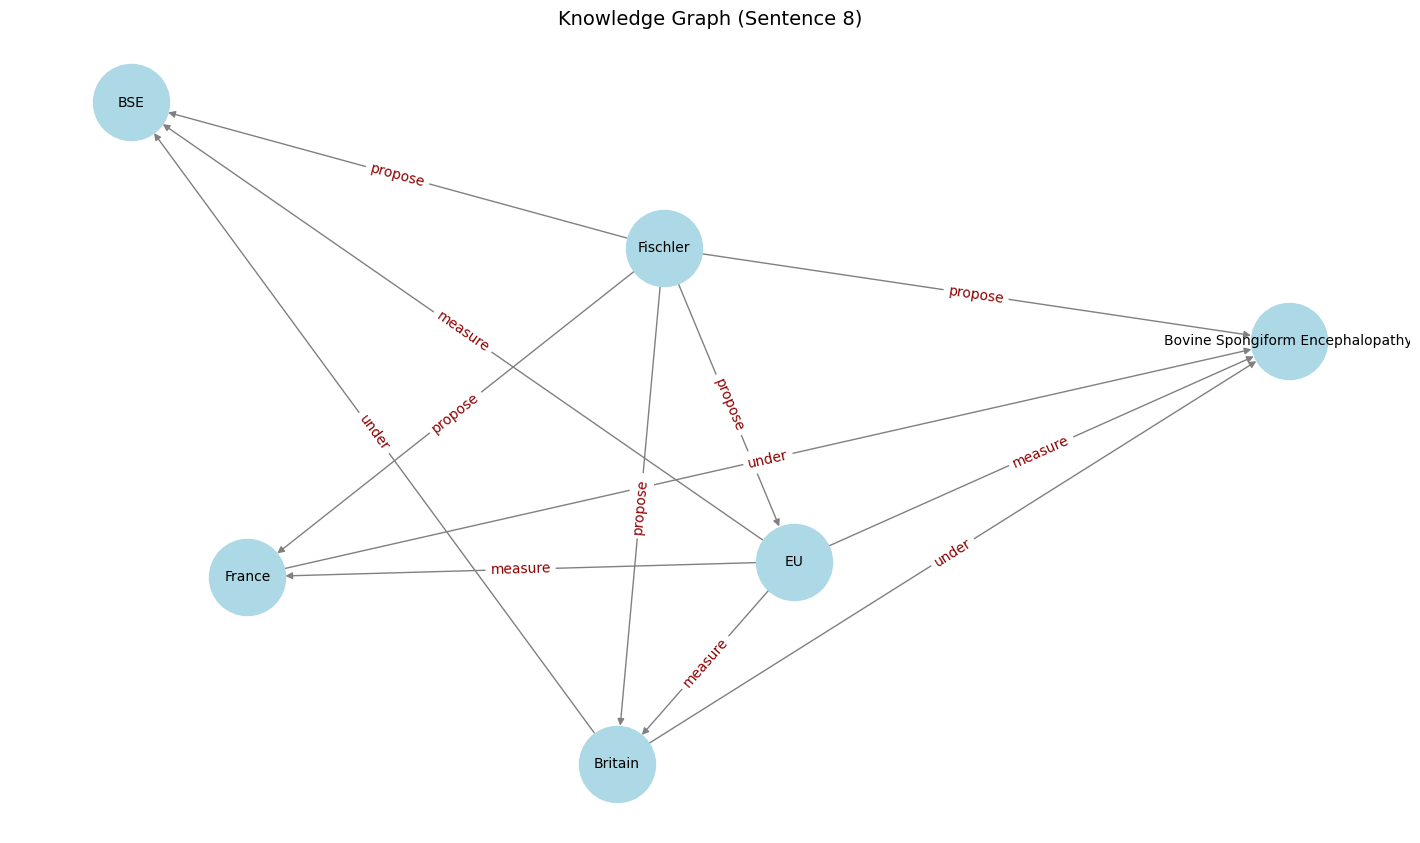

In [ ]:
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G, k=2.0, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, edge_color='gray', arrows=True)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')

plt.title("Knowledge Graph (Sentence 8)", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
displacy.render(docs[8][1], style='ent')

## Classification assessment

To evaluate classification metrics we have got to relabel spacy's annotation for it to be identical with CoNLL's one. We will begin with creating a new dataframe on previous spacy's dataframe basis. It exploits offsets_to_biluo_tags and then biluo_to_iob methods to get BIO-annotation that is used in initial CoNLL dataset.

In [ ]:
nlp = spacy.blank('en')
texts = {doc[0]: doc[1].text for doc in docs}
all_tokens = []
all_bio_tags = []
all_sentence_ids = []

for sent_id, group in df_spacy.groupby('Sentence_ID'):
    text = texts[sent_id]
    doc = nlp.make_doc(text)
    entities = []
    for idx, row in group.iterrows():
        start = row['Starting Position']
        end = row['Ending Position']
        label = row['Label']
        entities.append((start, end, label))
    biluo_tags = offsets_to_biluo_tags(doc, entities)
    bio_tags = biluo_to_iob(biluo_tags)
    all_tokens.extend([token.text for token in doc])
    all_bio_tags.extend(bio_tags)
    all_sentence_ids.extend([sent_id] * len(doc))

df_spacy_BIO = pd.DataFrame({
    "Sentence_ID": all_sentence_ids,
    "Entity": all_tokens,
    "BIO_Label": all_bio_tags
})

In [ ]:
df_spacy_BIO

,Sentence_ID,Entity,BIO_Label
0,0,EU,B-ORG
1,0,rejects,O
2,0,German,B-NORP
3,0,call,O
4,0,to,O
...,...,...,...
197707,14039,three,B-CARDINAL
197708,14040,Swansea,B-PERSON
197709,14040,1,I-PERSON
197710,14040,Lincoln,I-PERSON


CoNLL annotation also uses MISC term for entities other than ORG, PER and LOC.

In [ ]:
df_spacy_BIO.BIO_Label.unique()

array(['B-ORG', 'O', 'B-NORP', 'B-PERSON', 'I-PERSON', 'B-GPE', 'B-DATE',
       'I-DATE', 'I-ORG', 'B-LOC', 'B-CARDINAL', 'I-CARDINAL',
       'B-QUANTITY', 'I-QUANTITY', 'B-PERCENT', 'I-PERCENT', 'B-MONEY',
       'I-MONEY', 'B-LANGUAGE', 'I-LOC', 'B-TIME', 'I-TIME', 'B-ORDINAL',
       'B-EVENT', 'I-EVENT', 'B-PRODUCT', 'I-GPE', 'I-NORP', 'B-FAC',
       'I-FAC', 'B-LAW', 'I-LAW', 'B-WORK_OF_ART', 'I-WORK_OF_ART',
       'I-PRODUCT'], dtype=object)

In [ ]:
df_conll.Label.unique()

array(['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG',
       'I-MISC', 'I-LOC'], dtype=object)

That is why we should relabel annotation one more time.

In [ ]:
label_map = {'B-ORG': 'B-ORG', 'O': 'O', 'I-ORG': 'I-ORG', 'B-NORP': 'B-MISC', 'B-PERSON': 'B-PER', 'I-PERSON': 'I-PER', 'B-LOC': 'B-LOC', 'B-GPE': 'B-LOC', 'B-DATE': 'B-MISC',
       'I-DATE': 'I-MISC', 'B-CARDINAL': 'B-MISC', 'I-CARDINAL': 'I-MISC',
       'B-QUANTITY': 'B-MISC', 'I-QUANTITY': 'I-MISC', 'B-PERCENT': 'B-MISC', 'I-PERCENT': 'I-MISC', 'B-MONEY': 'B-MISC',
       'I-MONEY': 'I-MISC', 'B-LANGUAGE': 'B-MISC', 'B-TIME': 'B-MISC', 'I-TIME': 'I-MISC', 'B-ORDINAL': 'B-MISC',
       'B-EVENT': 'B-MISC', 'I-EVENT': 'I-MISC', 'B-PRODUCT': 'B-MISC', 'I-GPE': 'I-LOC', 'I-LOC': 'I-LOC', 'I-NORP': 'I-MISC', 'B-FAC': 'B-MISC',
       'I-FAC': 'I-MISC', 'B-LAW': 'B-MISC', 'I-LAW': 'I-MISC', 'B-WORK_OF_ART': 'B-MISC', 'I-WORK_OF_ART': 'I-MISC',
       'I-PRODUCT': 'I-MISC'}

df_spacy_BIO['BIO_Label'] = df_spacy_BIO['BIO_Label'].map(label_map)
df_spacy_BIO.BIO_Label.unique()

array(['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-MISC',
       'I-ORG', 'I-LOC'], dtype=object)

Let's merge the datasets and find the metrics.

In [ ]:
merged_df = pd.merge(df_conll, df_spacy_BIO, on=['Sentence_ID', 'Entity'], how='inner')

precision = precision_score(merged_df['Label'], merged_df['BIO_Label'], average='weighted')
recall = recall_score(merged_df['Label'], merged_df['BIO_Label'], average='weighted')
f1 = f1_score(merged_df['Label'], merged_df['BIO_Label'], average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Precision: 0.9098
Recall: 0.8230
F1: 0.8599
